%load_ext autotime

### Instructions
1. Seek to improve the one-layer model by changing the internal activation function. This will involve changing A1 to something else, and also changing the derivative involving one or both of dAI and dZ1.
2. Add another layer with your choice of activation function (other than the logistic function) and your choice of internal nodes
3. Add a third layer
4. Add a fourth layer
5. Report on your choices and assessment of the resulting models - you can extend the basic model assessment tools supplied
6. Based on your answers to tasks 1-4, write code that - for this dataset - allows a user to build and run a neural net with a high degree of flexibility in terms of architecture and hyperperameter choices.
7. Explain how advanced optimisers (e.g. Adam) would extend your code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Import the Dataset

df = pd.read_csv ('flower2D.csv')
print(df.shape)
print(df.info())
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

(400, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  400 non-null    int64  
 1   X1          400 non-null    float64
 2   X2          400 non-null    float64
 3   Y           400 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 12.6 KB
None


,X1,X2,Y
0,0.005257,-0.303586,0
1,0.996098,3.461645,0
2,0.384404,2.392678,0
3,0.951043,3.282709,0
4,0.091932,1.066689,0


In [29]:
X, y = df[["X1","X2"]], np.array(df["Y"])
n = 300
n_test = X.shape[0] - n
X_train, X_test = X[:n].values, X[n:].values       # shape (300, 2) and (n_test, 2)
y_train, y_test = y[:n].reshape(-1,1), y[n:].reshape(-1,1)  # shape (300,1)

# X_mean = X_train.mean(axis=0)
# X_std = X_train.std(axis=0)
# X_train = (X_train - X_mean) / X_std
# X_test = (X_test - X_mean) / X_std

In [30]:
y_train.shape, y_test.shape

((300, 1), (100, 1))

In [31]:
print("Unique test labels and counts:", np.unique(y_test, return_counts=True))

Unique test labels and counts: (array([0, 1]), array([50, 50]))


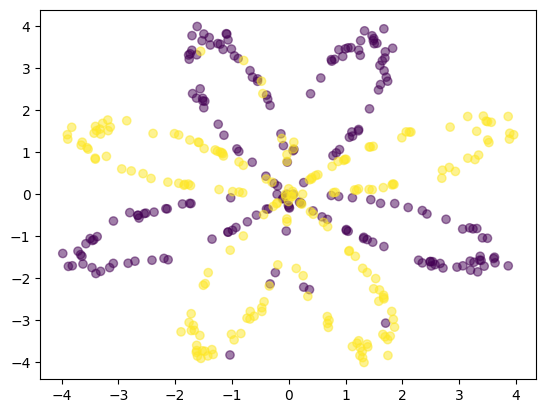

In [4]:
### Visualize the data
plt.scatter(df.X1, df.X2, c=df.Y, alpha=0.5)
plt.show()

### Shuffle the data
df = df.sample(frac=1)

### Preprocess into test and train sets

dataset, testDataset = np.split(df, [int(.7 * len(df))])
X = dataset.drop ('Y' , axis=1)
y = dataset['Y']
XX = testDataset.drop('Y', axis=1)
yy = testDataset['Y']

#### Loss & functions

In [5]:
def binary_cross_entropy(Y, Y_hat):
    m = Y.shape[0]
    return -(1/m) * np.sum(Y * np.log(Y_hat + 1e-15) + (1 - Y) * np.log(1 - Y_hat + 1e-15))

def binary_cross_entropy_grad(Y, Y_hat):
    m = Y.shape[0]
    return (Y_hat - Y) / m

#### Neural network design
#### Activation Layers

In [6]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, grad_output):
        return grad_output * self.out * (1 - self.out)

    def parameters_and_gradients(self):
        return []

class Relu:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = np.maximum(0, x)
        return self.out

    def backward(self, grad_output):
        return grad_output * (self.out > 0)

    def parameters_and_gradients(self):
        return []

#### Linear layer

In [7]:
class Linear:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
        self.biases = np.zeros((1, output_dim))
        self.input = None
        self.grad_weights = None
        self.grad_biases = None

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, grad_output):
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)

    def parameters_and_gradients(self):
        return [(self.weights, self.grad_weights),
                (self.biases, self.grad_biases)]

#### Neural Network

In [8]:
class NeuralNetwork:
    def __init__(self, layers=[]):
        self.layers = layers

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output):
        gradient_input = grad_output
        for layer in reversed(self.layers):
            gradient_input = layer.backward(gradient_input)

    def parameters_and_gradients(self):
        params_and_grads = []
        for layer in self.layers:
            params_and_grads.extend(layer.parameters_and_gradients())
        return params_and_grads

### No hidden layers

In [16]:
nn = NeuralNetwork([
    Linear(X_train.shape[1], 1),  # input_dim = n_features
    Sigmoid()
])

learning_rate = 0.01
num_epochs = 2000

for i in range(num_epochs):
    # Forward pass
    y_hat = nn.forward(X_train)

    # Compute loss
    loss = binary_cross_entropy(y_train, y_hat)

    # Backward pass
    grad_loss = binary_cross_entropy_grad(y_train, y_hat)
    nn.backward(grad_loss)

    # Update parameters
    for param, grad in nn.parameters_and_gradients():
        param -= learning_rate * grad

    # Optional: print loss every 200 epochs
    if i % 200 == 0:
        print(f"Epoch {i}, loss: {loss:.4f}")

for param, _ in nn.parameters_and_gradients():
    print(param)

Epoch 0, loss: 0.8137
Epoch 200, loss: 0.7504
Epoch 400, loss: 0.7156
Epoch 600, loss: 0.6934
Epoch 800, loss: 0.6766
Epoch 1000, loss: 0.6626
Epoch 1200, loss: 0.6505
Epoch 1400, loss: 0.6400
Epoch 1600, loss: 0.6313
Epoch 1800, loss: 0.6242
[[ 0.21445287]
 [-0.3143507 ]]
[[-0.3654179]]


In [17]:
# Print the learned weights and bias
for layer in nn.layers:
    if isinstance(layer, Linear):
        print("Weights:\n", layer.weights)
        print("Bias:\n", layer.biases)

Weights:
 [[ 0.21445287]
 [-0.3143507 ]]
Bias:
 [[-0.3654179]]


In [33]:

y_hat_test = nn.forward(X_test)


predictions = (y_hat_test > 0.5).astype(int)
labels = (y_test > 0.5).astype(int)


predictions = predictions.flatten()
labels = labels.flatten()


tp = np.sum((predictions == 1) & (labels == 1))
tn = np.sum((predictions == 0) & (labels == 0))
fp = np.sum((predictions == 1) & (labels == 0))
fn = np.sum((predictions == 0) & (labels == 1))


cm = np.array([[tn, fp],
               [fn, tp]])

print("Confusion matrix:\n", cm)


model_score = (tn + tp) / (tn + fp + fn + tp)
print("Model score:", model_score)

Confusion matrix:
 [[39 11]
 [32 18]]
Model score: 0.57


In [34]:
print("Unique test labels and counts:", np.unique(y_test, return_counts=True))

Unique test labels and counts: (array([0, 1]), array([50, 50]))


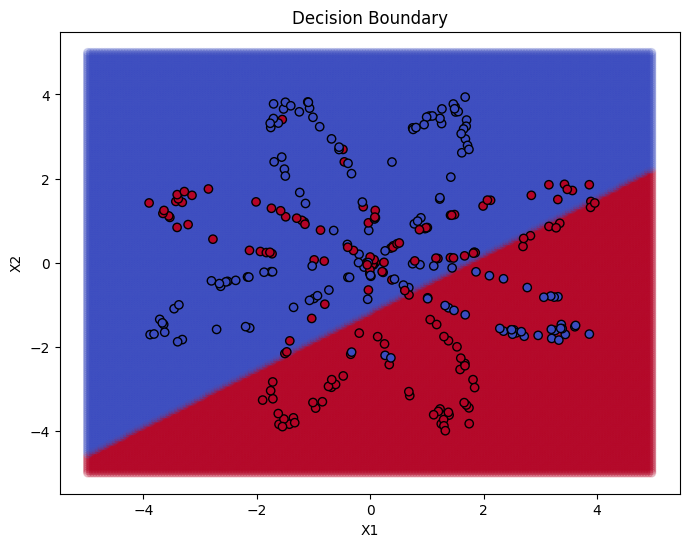

In [35]:
X_np = X.values

x_min, x_max = X_np[:,0].min() - 1, X_np[:,0].max() + 1
y_min, y_max = X_np[:,1].min() - 1, X_np[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
mypoints = np.c_[xx.ravel(), yy.ravel()]

Z = nn.forward(mypoints)
preds = (Z > 0.5).astype(int).flatten()

# Plot decision boundary
plt.figure(figsize=(8,6))
plt.scatter(mypoints[:,0], mypoints[:,1], c=preds, alpha=0.2, cmap='coolwarm')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train.flatten(), edgecolor='k', cmap='coolwarm')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Boundary')
plt.show()

#### With 1 hidden layer

In [20]:
hidden_units = 100

nn_2 = NeuralNetwork([
    Linear(X_train.shape[1], hidden_units),
    Relu(),
    Linear(hidden_units, 1),
    Sigmoid()
])

learning_rate = 0.01
num_epochs = 2000

for i in range(num_epochs):
    # Forward pass
    y_hat = nn_2.forward(X_train)

    # Compute loss
    loss = binary_cross_entropy(y_train, y_hat)

    # Backward pass
    grad_loss = binary_cross_entropy_grad(y_train, y_hat)
    nn_2.backward(grad_loss)

    # Update parameters
    for param, grad in nn_2.parameters_and_gradients():
        param -= learning_rate * grad

    if i % 200 == 0:
        print(f"Epoch {i}, loss: {loss:.4f}")


Epoch 0, loss: 2.2618
Epoch 200, loss: 0.8415
Epoch 400, loss: 0.5191
Epoch 600, loss: 0.5210
Epoch 800, loss: 0.5282
Epoch 1000, loss: 0.5364
Epoch 1200, loss: 0.5448
Epoch 1400, loss: 0.5534
Epoch 1600, loss: 0.5619
Epoch 1800, loss: 0.5703


In [21]:
y_hat_test = nn_2.forward(X_test)


predictions = (y_hat_test > 0.5).astype(int)
labels = (y_test > 0.5).astype(int)


predictions = predictions.flatten()
labels = labels.flatten()


tp = np.sum((predictions == 1) & (labels == 1))
tn = np.sum((predictions == 0) & (labels == 0))
fp = np.sum((predictions == 1) & (labels == 0))
fn = np.sum((predictions == 0) & (labels == 1))


cm = np.array([[tn, fp],
               [fn, tp]])

print("Confusion matrix:\n", cm)


model_score = (tn + tp) / (tn + fp + fn + tp)
print("Model score:", model_score)

Confusion matrix:
 [[ 0  0]
 [98  2]]
Model score: 0.02


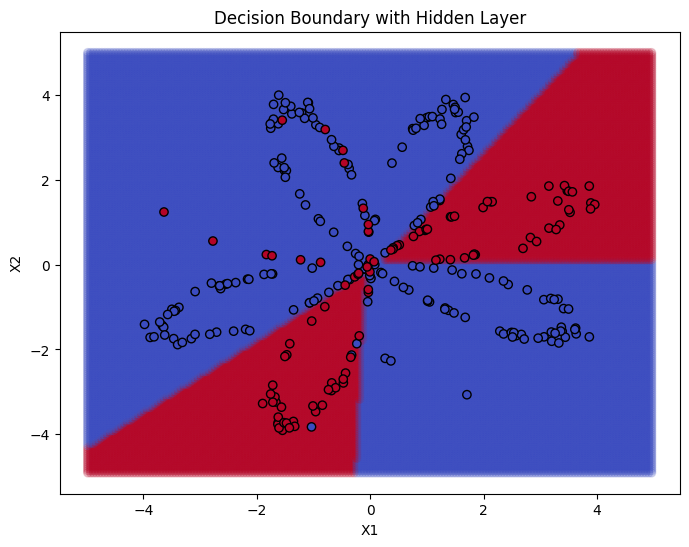

In [22]:
X_np = X_train
x_min, x_max = X_np[:,0].min() - 1, X_np[:,0].max() + 1
y_min, y_max = X_np[:,1].min() - 1, X_np[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
mypoints = np.c_[xx.ravel(), yy.ravel()]

Z = nn_2.forward(mypoints)
preds = (Z > 0.5).astype(int).flatten()

plt.figure(figsize=(8,6))
plt.scatter(mypoints[:,0], mypoints[:,1], c=preds, alpha=0.2, cmap='coolwarm')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train.flatten(), edgecolor='k', cmap='coolwarm')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Boundary with Hidden Layer')
plt.show()